# Training feature selection

## Description

...


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import json
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import numpy as np
import pandas as pd
from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings  # Import the warnings module

import matplotlib.colors as mcolors

from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load training data and label dictionary

We will load the training data saved from the [feature extracion notebook](3_Training_feature_extraction.ipynb), along with the mapping between crop labels and the numerical classes.

In [2]:
min_valid_weeks = 24  # Minimum number of valid weeks for a dataset to be included in the analysis
# dataset_name with min_valid_weeks in the name
dataset_name = 'SB10r'
dataset_suffix = '_n0.2_process_filt'


In [3]:
base_path = 'InputModel'
output_file = os.path.join(base_path, f'{dataset_name}{dataset_suffix}.csv')

# Load the newly generated CSV file
df = pd.read_csv(output_file)
# print the number of rows
print(f"Number of rows: {len(df)}")
df = df.dropna()
print(df.shape)

Number of rows: 2603423
(2603423, 60)


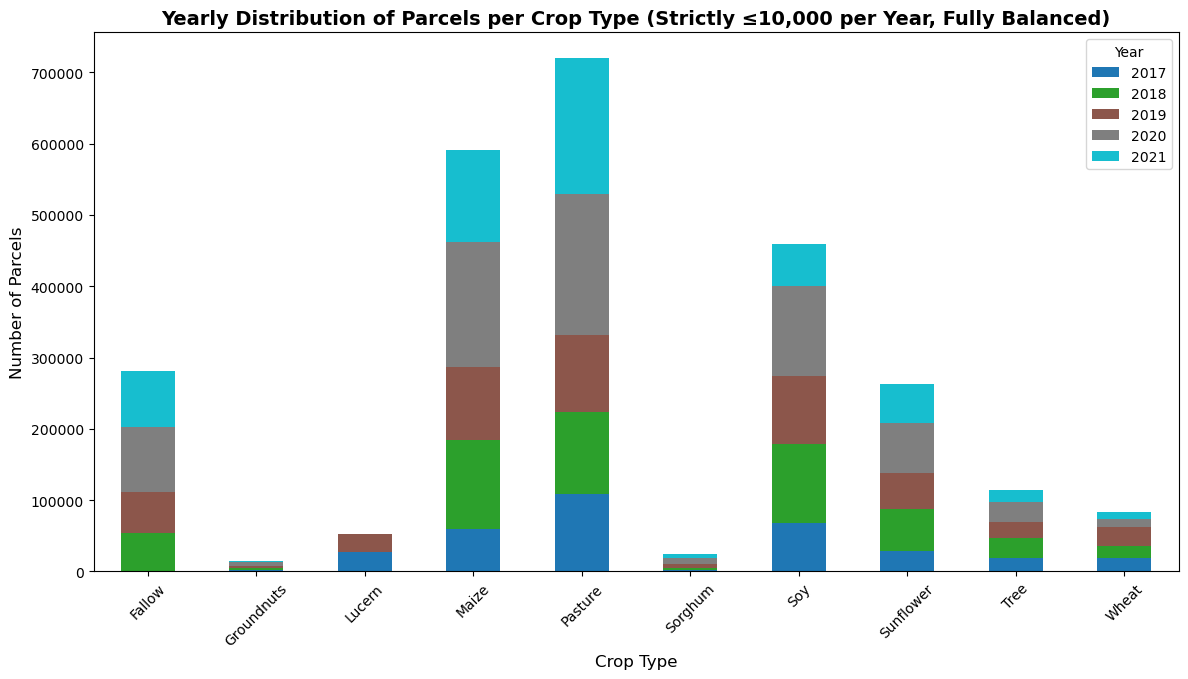

In [4]:
# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()

In [5]:
df1 = df.copy()

In [6]:
# Identify vegetation and SAR predictor columns
veg_predictors = [col for col in df1.columns if col.startswith('veg_')]
sar_predictors = [col for col in df1.columns if col.startswith('sar_')]

# Define crop-specific invalid week rules
def is_invalid_sample(crop, week, irrigation):
    invalid_weeks = {
        "Maize": (22, 40), "Soy": (22, 40), "Sunflower": (22, 40),
        "Pasture": (22, 40), "Tree": (22, 40), "Fallow": (22, 40),
        "Groundnuts": (22, 40), "Sorghum": (22, 40), "Wheat": (47, 17)
    }
    if crop == "Lucern":
        return week < 17 or week > 47 if irrigation == 1 else 22 <= week <= 40
    if crop in invalid_weeks:
        out_start, out_end = invalid_weeks[crop]
        if out_start < out_end:
            return out_start <= week <= out_end
        else:
            return week >= out_start or week <= out_end
    return False

# Step 1: Mark valid crop weeks
df1['is_valid_week'] = ~df1.apply(lambda row: is_invalid_sample(
    row['Crop_type'], row['week'], row['Irrigation']), axis=1)

# Step 2: Filter only valid crop weeks
df_valid = df1[df1['is_valid_week']].copy()

# Step 3: For each FIELDID-Year-Crop_type, count valid rows where all veg_ and sar_ predictors are present
group_cols = ['FIELDID', 'Year', 'Crop_type']
valid_counts = (
    df_valid
    .groupby(group_cols, group_keys=False)
    .apply(lambda group: pd.Series({
        'veg_valid': group[veg_predictors].notnull().all(axis=1).sum(),
        'sar_valid': group[sar_predictors].notnull().all(axis=1).sum()
    }))
    .reset_index()
)

# Step 4: Keep groups with ≥ selected_number fully valid veg and sar weeks
valid_triplets = valid_counts[
    (valid_counts['veg_valid'] >= min_valid_weeks) &
    (valid_counts['sar_valid'] >= min_valid_weeks)
][group_cols]

# Step 5: Filter the original df1 to retain only valid (FIELDID, Year, Crop_type) combinations
df2 = df1.merge(valid_triplets, on=group_cols, how='inner').drop(columns=['is_valid_week'])

# Step 6: Optional summary
print(f"Original FIELDID-Year-Crop groups: {df1[group_cols].drop_duplicates().shape[0]}")
print(f"Filtered groups retained: {df2[group_cols].drop_duplicates().shape[0]}")
print(f"Remaining rows in df2: {df2.shape[0]}")


/var/folders/jz/41vp_9w11rj9bnb6_5xhp_gw0000gn/T/ipykernel_26177/4230649486.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid


Original FIELDID-Year-Crop groups: 193102
Filtered groups retained: 4110
Remaining rows in df2: 110904


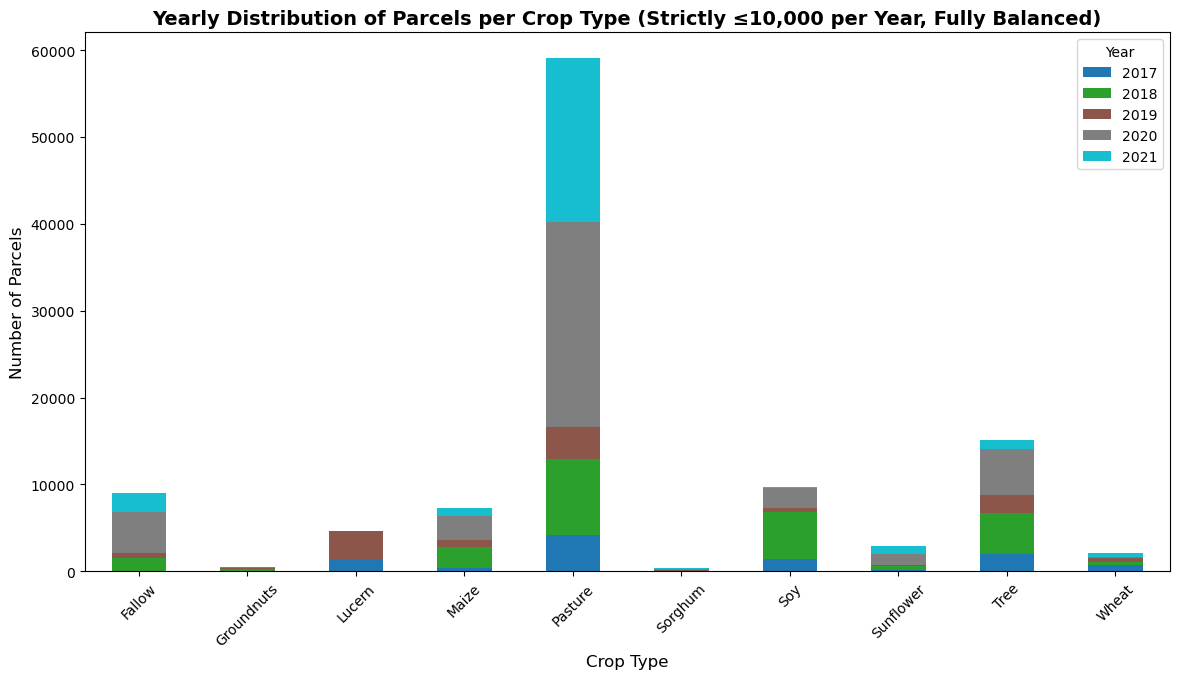

In [7]:
# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df2.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()

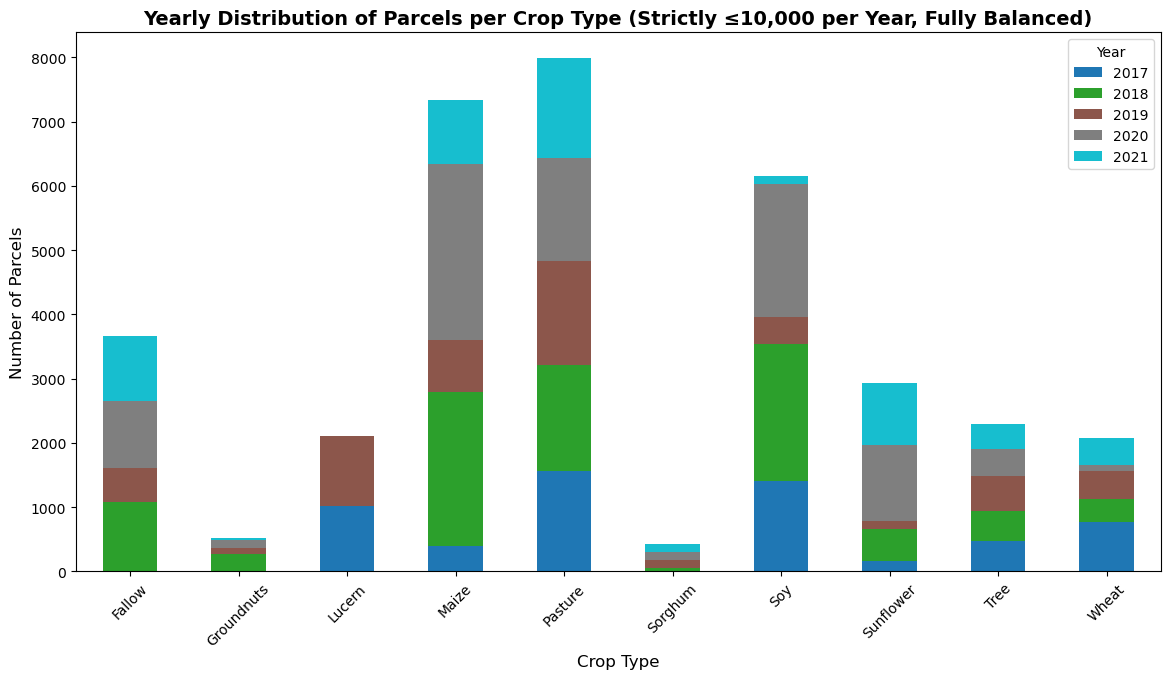

In [17]:
# Ensure required columns exist
required_columns = {"Crop_type", "FIELDID", "Year"}
missing = required_columns - set(df2.columns)
if missing:
    raise ValueError(f"The dataframe df2 is missing the columns: {missing}")

# 10: Define max parcels per crop *per year*
max_parcels_dict = {
    "Maize": 100000,
    "Soy": 80,
    "Sunflower": 100000,
    "Wheat": 100000,
    "Lucern": 40,
    "Pasture": 60,
    "Tree": 15,
    "Fallow": 40,
    "Groundnuts": 100000,
    "Sorghum": 100000
}

# Start with an empty list to collect filtered data
balanced_parts = []

# Loop through crops and years
for crop, max_per_year in max_parcels_dict.items():
    crop_df = df2[df2["Crop_type"] == crop]

    for year, year_df in crop_df.groupby("Year"):
        unique_fieldids = year_df["FIELDID"].unique()
        if len(unique_fieldids) <= max_per_year:
            selected_ids = unique_fieldids  # keep all
        else:
            selected_ids = np.random.choice(unique_fieldids, size=max_per_year, replace=False)

        # Keep only selected FIELDIDs
        filtered_df = year_df[year_df["FIELDID"].isin(selected_ids)]
        balanced_parts.append(filtered_df)

# Combine all filtered parts
df2_balanced = pd.concat(balanced_parts, ignore_index=True)

# Compute counts after rebalancing
crop_year_counts_balanced = df2_balanced.groupby(["Crop_type", "Year"])["FIELDID"].nunique().unstack()



# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df2_balanced.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()


<AxesSubplot:xlabel='Crop_type'>

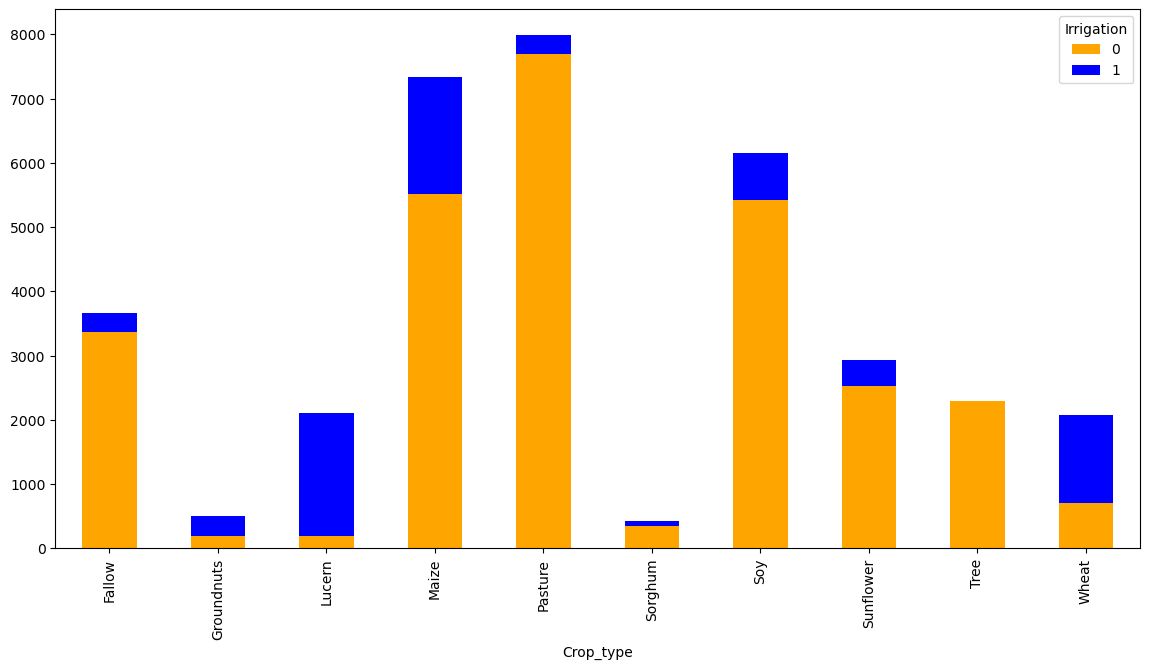

In [18]:
# plot histogram of Irrigation by Crop_type
df2_balanced.groupby(['Crop_type', 'Irrigation']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['orange', 'blue'],  # 0 = orange (Rainfed), 1 = blue (Irrigated)
    figsize=(14, 7)
)

In [19]:
# Save df_limited to a new CSV file
out_path = 'InputModel'
# Save both df1 and df1_balanced to CSV files
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [20]:
# SB{min_valid_weeks}r
output_filename = os.path.join(out_path, f'SB{min_valid_weeks}r{dataset_suffix}.csv')
# save df2_balanced to a new CSV file
df2_balanced.to_csv(output_filename, index=False)

In [12]:
# df_map = df2_balanced.copy()

# # Merge both datasets (all parcels)
# gdf_fs = gpd.read_file(os.path.join("Data/geo/parcels", "FS.geojson"))
# gdf_nw = gpd.read_file(os.path.join("Data/geo/parcels", "NW.geojson"))

# # Ensure both datasets have a geometry column
# if "geometry" not in gdf_fs.columns or "geometry" not in gdf_nw.columns:
#     raise ValueError("One of the datasets is missing a geometry column.")

# # Merge into gdf_total (all parcels)
# gdf_total = pd.concat([gdf_fs, gdf_nw], axis=0, ignore_index=True)

# # Ensure 'geometry' exists and is valid
# if "geometry" not in gdf_total.columns:
#     raise ValueError("gdf_total is missing the geometry column after merging.")

# # Drop rows with missing geometry
# gdf_total = gdf_total.dropna(subset=['geometry'])
# gdf_total = gpd.GeoDataFrame(gdf_total, geometry='geometry', crs=gdf_fs.crs)

# # Count total unique parcels
# total_parcels = gdf_total['FIELDID'].nunique()

# # **Fix missing geometry in df**
# if "geometry" not in df_map.columns:
#     print("Restoring geometry column in df...")
#     df_map = df_map.merge(gdf_total[['FIELDID', 'geometry']], on='FIELDID', how='left')

# # Ensure geometry exists before proceeding
# df_map = df_map.dropna(subset=['geometry'])  # Remove rows where geometry is missing
# gdf_crop = gpd.GeoDataFrame(df_map, geometry='geometry', crs=gdf_fs.crs)

# # Ensure Crop_type column exists before proceeding
# if "Crop_type" not in gdf_crop.columns:
#     raise ValueError("The dataframe df is missing the 'Crop_type' column.")

# # Count unique FIELDID values per Crop_type
# crop_counts = gdf_crop.groupby('Crop_type')['FIELDID'].nunique().to_dict()  # Count unique parcels

# # Count unique parcels in gdf_crop
# crop_parcels = gdf_crop['FIELDID'].nunique()

# # Define distinct colors for each crop type
# colors = plt.cm.get_cmap('tab10', len(crop_counts))  # Use 'tab10' for distinct colors
# crop_color_map = {crop: colors(i) for i, crop in enumerate(crop_counts.keys())}

# # Plot the map
# fig, ax = plt.subplots(figsize=(12, 12))

# # Plot total parcels as a soft gray background
# gdf_total.plot(ax=ax, color='lightgray', edgecolor='none', alpha=0.5)

# # Overlay parcels colored by crop type
# gdf_crop.plot(ax=ax, color=gdf_crop['Crop_type'].map(crop_color_map), edgecolor='white', linewidth=0.3, alpha=0.8)

# # Create a legend with crop type and unique parcel count
# legend_labels = [f"{c} ({crop_counts[c]})" for c in crop_counts.keys()]
# handles = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=crop_color_map[c], markersize=10)
#     for c in crop_counts.keys()
# ]

# # Update legend title to include both total and crop parcel counts
# legend_title = f"Crop Type (Parcels)\nTotal Parcels: {total_parcels}\nCrop Parcels: {crop_parcels}"

# ax.legend(handles, legend_labels, title=legend_title, loc='upper right')

# # Improve title and axis labels
# ax.set_title("Parcels Map Colored by Crop Type", fontsize=14, fontweight='bold')
# ax.set_xlabel("Longitude", fontsize=12)
# ax.set_ylabel("Latitude", fontsize=12)